# Watch Gliding Trajectories

In [ ]:
import numpy as np
from scipy.io import loadmat, savemat
# from scipy.optimize import curve_fit 
# from scipy.stats import ttest_ind
# from scipy import stats
# import scipy.signal
# import seaborn as sns
# from tqdm import tqdm
# from scipy.signal import savgol_filter
# import peakutils
import copy
# from scipy import signal

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
# from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

# Auxiliary functions

## Variables and files

In [19]:
# Convert a string of a variable name to the variable itself
def str2var(string):
    return globals()[string]

In [20]:
# Open .mat for holography experiments
def open_xyz_mat(pathname, upward=False, version='new'):
    data = loadmat(pathname, squeeze_me=True)
    if version == 'new':
        raw_data = np.zeros((len(data['x']), 3))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
    elif version == 'old':
        raw_data = data["data"][:, 0:3]
    elif version == 'err':
        raw_data = np.zeros((len(data['x']), 7))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
        raw_data[:,3] = data['dx']
        raw_data[:,4] = data['dy']
        raw_data[:,5] = data['dz']
        raw_data[:,6] = data['redchi']
    elif version == 'xyzrn':
        raw_data = np.zeros((len(data['x']), 5))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
        raw_data[:,3] = data['a_p']
        raw_data[:,4] = data['n_p']
    else:
        print("Unknown version.")
        print("Try again.")
        # version = str(input("Data version?"))
        # raw_data = open_xyz_mat(pathname, upward=upward, version=version)
    if upward:
        raw_data[:,2] = - raw_data[:,2]
    del data
    return raw_data

In [21]:
def find_rn(filepath):
    """
    Find the radius of the particle in the file path. 
    The trajectory (.mat) should be in the last folder considered.
    """
    try:
        filename = filepath[filepath.rfind('/')+1:]
        r = float(filename[filename.find('_rp_')+4:filename.find('_np_')].replace('p','.')) * 1e-6
        n_p = float(filename[filename.find('_np_')+4:filename.find('_vid')].replace('p','.'))
    except:
        print(filepath)
        r = input("Enter the radius in um = ")
        r = float(r) * 1e-6
        n_p = input("Enter the refractive index = ")
        n_p = float(n_p)
    return r, n_p

In [22]:
def remove_end_zeros(data):
    try:
        ind = list(data[:,0]).index(0)
        data = data[:ind,:]
    except ValueError:
        print('No pb. No zero in raw data.')
    return data

In [23]:
def unpack_data(data, full=False):
    if full:
        x, y, z = data[:,0], data[:,1], data[:,2]
        dx, dy, dz = data[:,3], data[:,4], data[:,5]
        redchi = data[:,6]
        return x, y, z, dx, dy, dz, redchi
    else:
        x, y, z = data[:,0], data[:,1], data[:,2]
        return x, y, z

# Load the data

## Define paths and prepare the loading

We load every experiments that is considered good (holograms that are symmetric and circular) from the experiment point of view.

In [24]:
# Datas must be given in SI

# Load the .mat files and convert them into np.ndarrays
# Via the aux function open_xyz_mat

# Datas are stored in a arrays: xxx, yyy, zzz, etc.

In [25]:
# First experimental condition
# Chlamys under blue light for a while then recording 

dirs = [
    './data/20240702/2/tracking_saving_everything/traj_rp_4p1575_np_1p398_vid_tracking_saving_everything_all.mat', 
    './data/20240710/6/traj_rp_3p7589_np_1p4043_vid_6.mat', 
    './data/20240711/1_trim/traj_rp_3p0426_np_1p3913_vid_1_trim.mat', 
    './data/20240712/2_trim/traj_rp_3p2102_np_1p4051_vid_2_trim.mat',
    # './data/20240712/3/traj_rp_4p4067_np_1p3955_vid_3.mat', 
    './data/20240712/4/traj_rp_4p9586_np_1p3926_vid_4.mat',
    './data/20240716/3/traj_rp_4p2123_np_1p3969_vid_3.mat',
    './data/20240716/4/traj_rp_4p199_np_1p401_vid_4.mat', 
    './data/20240716/5/traj_rp_3p7412_np_1p4022_vid_5.mat', 
    './data/20240717/2/traj_rp_3p3411_np_1p3994_vid_2.mat', 
    './data/20240717/3/traj_rp_2p9238_np_1p3951_vid_3.mat', 
    './data/20240717/4/traj_rp_3p4785_np_1p3977_vid_4.mat', 
    './data/20240718/1/traj_rp_3p6178_np_1p3985_vid_1.mat', 
    './data/20240718/2/traj_rp_3p6679_np_1p4_vid_2.mat', 
    './data/20240718/4/traj_rp_3p5684_np_1p4021_vid_4.mat', 
    './data/20240719/1/traj_rp_3p0909_np_1p4147_vid_1.mat', 
    './data/20240719/2/traj_rp_3p1909_np_1p4037_vid_2.mat', 
    './data/20240719/3/traj_rp_3p3515_np_1p4106_vid_3.mat', 
    './data/20240719/4/traj_rp_2p7599_np_1p4309_vid_4.mat', 
    './data/20240723/2/traj_rp_3p1505_np_1p4031_vid_2.mat', 
    './data/20240723/2_trim/traj_rp_3p2447_np_1p3992_vid_2_trim.mat', 
    './data/20240723/4/traj_rp_2p8087_np_1p4049_vid_4.mat', 
    './data/20240723/4_trim/traj_rp_2p7824_np_1p4012_vid_4_trim.mat', 
    './data/20240723/5/traj_rp_3p6434_np_1p4003_vid_5.mat', 
    './data/20240723/6/traj_rp_3p4715_np_1p3986_vid_6.mat', 
]

fpss = [50] * len(dirs)

powers = [np.nan] * len(dirs)

wavelengths = [0.532] * len(dirs)

viscosity_out = [0.001] * len(dirs)

N = len(dirs)

radii = [find_rn(path) for path in dirs]

datas = [open_xyz_mat(dirs[i], upward=False, version='new') for i in range(len(dirs))]

In [26]:
# Remove zeros at the end of the trajectories 
for j in range(len(dirs)):
    datas[j] = remove_end_zeros(datas[j])

No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.


In [27]:
Ntot = len(dirs)
int(Ntot)

24

In [28]:
Nmax = max([len(datas[i][:,0]) for i in range(len(dirs))])

In [29]:
# xxx = np.ones((Nmax, Ntot)) * np.nan
# yyy = np.ones((Nmax, Ntot)) * np.nan
# zzz = np.ones((Nmax, Ntot)) * np.nan
# ttt = np.ones((Nmax, Ntot)) * np.nan

# for j, data in enumerate(datas):
#     x, y, z = data[:,0], data[:,1], data[:,2]
#     xxx[:len(x),j] = np.copy(x)
#     yyy[:len(x),j] = np.copy(y)
#     zzz[:len(x),j] = np.copy(z)
#     fps = fpss[j]
#     t = np.arange(len(x)) / fps
#     ttt[:len(x),j] = np.copy(t)

# rrr = np.sqrt((xxx - xxx[0,:]) ** 2 + (yyy - yyy[0,:]) ** 2)

# del j, data, x, y, z, t, fps

pos = np.ones((Nmax, 5, Ntot)) * np.nan

for j, data in enumerate(datas):
    x, y, z = data[:,0], data[:,1], data[:,2]
    pos[:len(x),0,j] = np.copy(x)
    pos[:len(x),1,j] = np.copy(y)
    pos[:len(x),2,j] = np.copy(z)
    r = np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)
    pos[:len(x),3,j] = np.copy(r)
    fps = fpss[j]
    t = np.arange(len(x)) / fps
    pos[:len(x),-1,j] = np.copy(t)

del j, data, x, y, z, r, t, fps

In [30]:
del datas

# Plot Every Trajectories

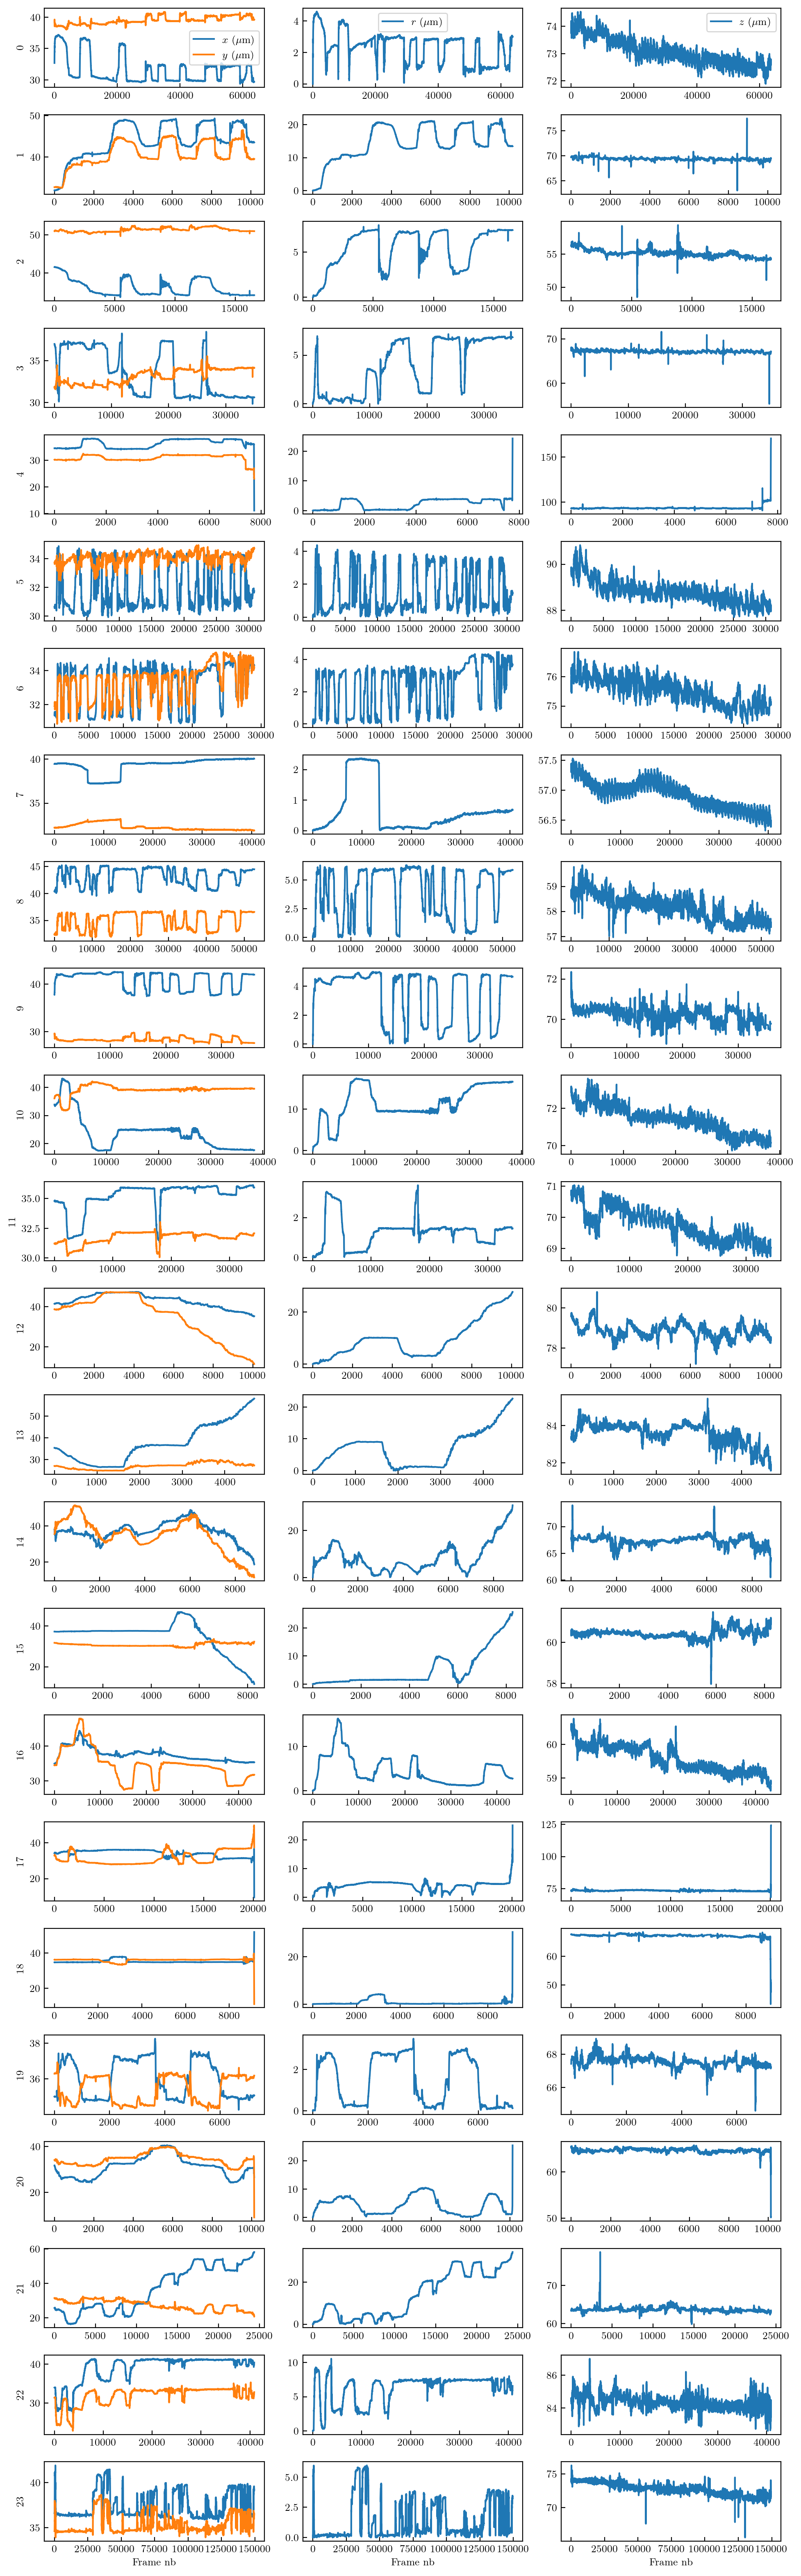

In [31]:
# Plot all the trajectories

fig, axes = plt.subplots(Ntot, 3, figsize=(25/2.54, 80/2.54))

for j in range(Ntot):
    x, y, z, r, t = pos[:,:,j].T

    axes[j,0].plot(x * 1e6, label=r'$x$ ($\mathrm{\mu m}$)')
    axes[j,0].plot(y * 1e6, label=r'$y$ ($\mathrm{\mu m}$)')
    axes[j,1].plot(r * 1e6, label=r'$r$ ($\mathrm{\mu m}$)')
    axes[j,2].plot(z * 1e6, label=r'$z$ ($\mathrm{\mu m}$)')
    axes[j,0].set_ylabel(j)

for j in range(3):
    axes[0,j].legend()
    axes[-1,j].set_xlabel('Frame nb')


plt.tight_layout()
plt.show()

In [42]:
def pos2nan(j, start=0, stop=None):
    if stop == None:
        stop = len(pos[:,0,j])
    pos[start:stop,:,j] = np.ones_like(pos[start:stop,:,j]) * np.nan

pos2nan(0, 0, 20000)
pos2nan(1, 0, 2500)

pos2nan(4, start=7000)
pos2nan(17, 19000)
pos2nan(18, 8000)

pos2nan(20, 10000)

pos2nan(23, 0, 5000)
pos2nan(23, start=25000)

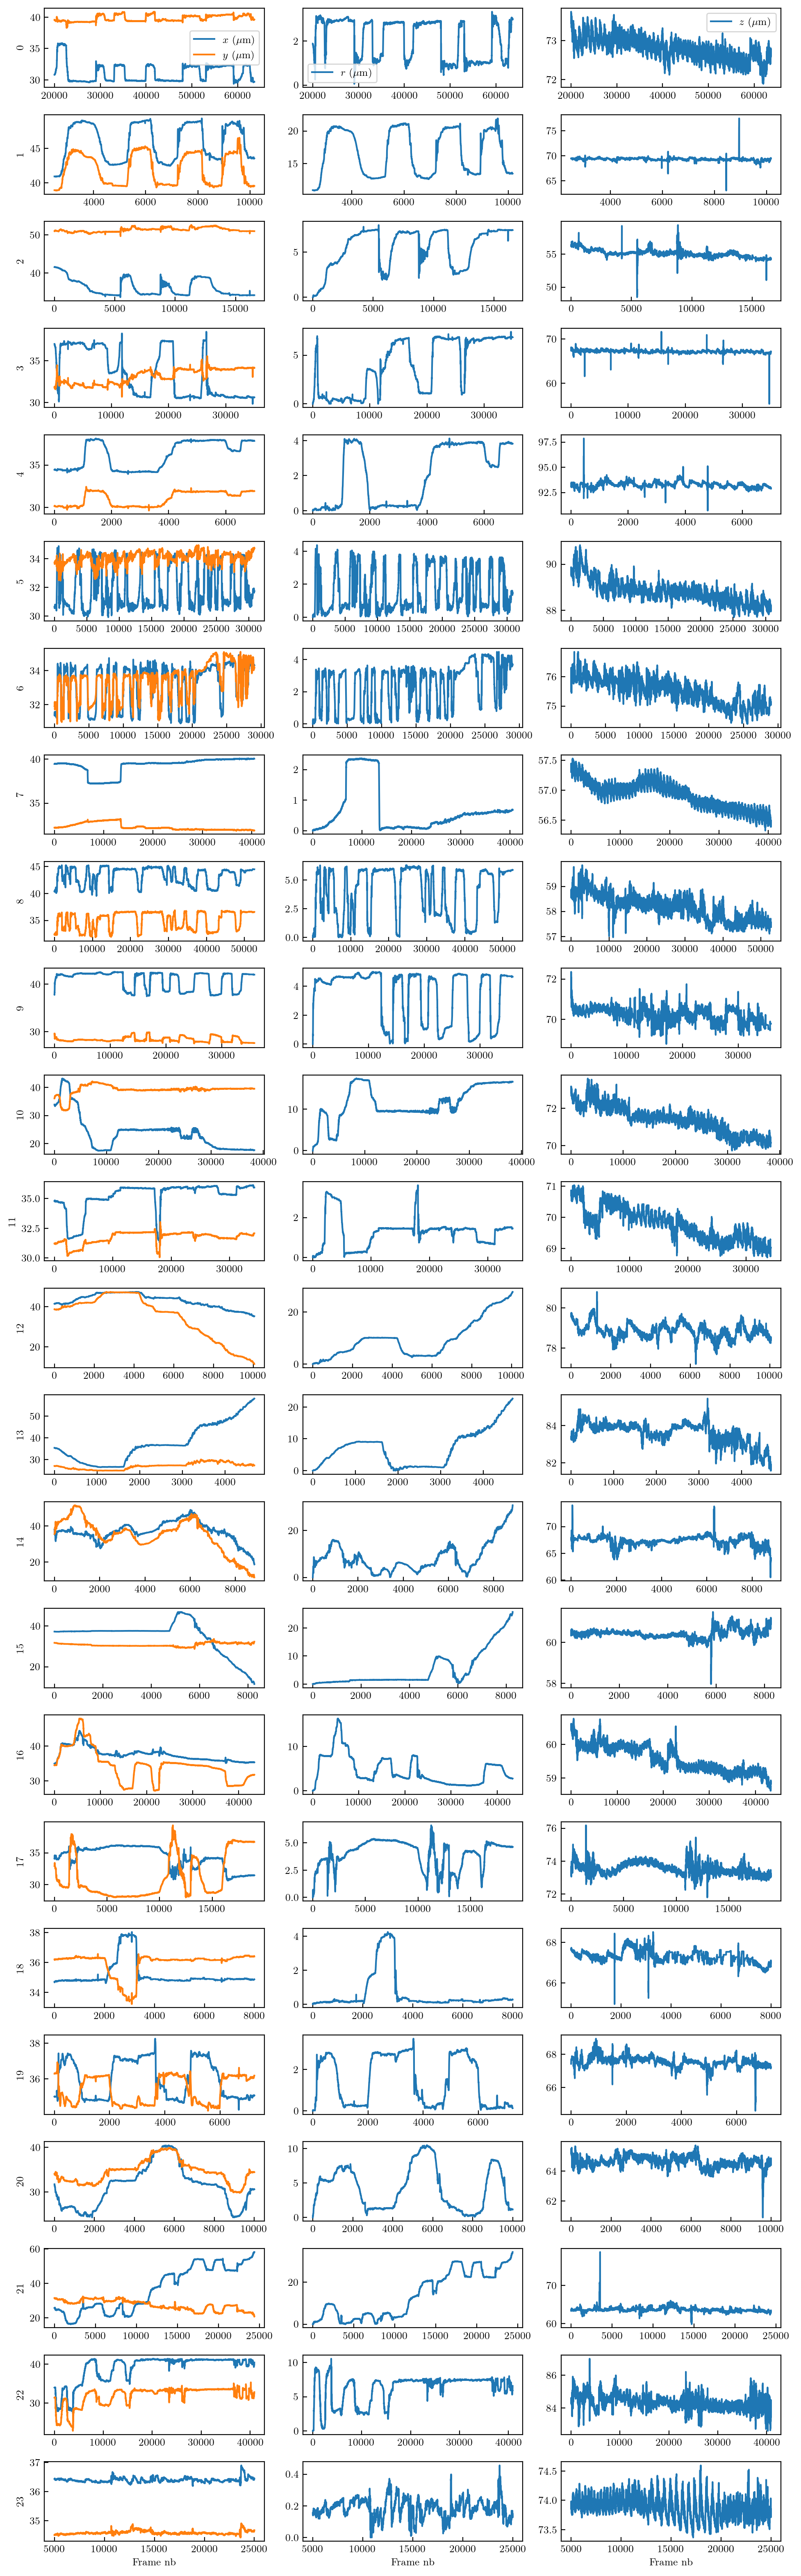

In [43]:
# Plot all the trajectories

fig, axes = plt.subplots(Ntot, 3, figsize=(25/2.54, 80/2.54))

for j in range(Ntot):
    x, y, z, r, t = pos[:,:,j].T

    axes[j,0].plot(x * 1e6, label=r'$x$ ($\mathrm{\mu m}$)')
    axes[j,0].plot(y * 1e6, label=r'$y$ ($\mathrm{\mu m}$)')
    axes[j,1].plot(r * 1e6, label=r'$r$ ($\mathrm{\mu m}$)')
    axes[j,2].plot(z * 1e6, label=r'$z$ ($\mathrm{\mu m}$)')
    axes[j,0].set_ylabel(j)

for j in range(3):
    axes[0,j].legend()
    axes[-1,j].set_xlabel('Frame nb')


plt.tight_layout()
plt.show()

In [40]:
x, y, z, r, t = pos[:,:,23].T

In [41]:
x

array([           nan,            nan,            nan, ...,
                  nan,            nan, 3.92152471e-05], shape=(149433,))